<a href="https://colab.research.google.com/github/ksokoll/Destatis_Revenue_Analysis/blob/main/Revenue_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

In this Analysis we will dive into a reallife destatis genesis dataset which is available online under the below link. The content of the dataset leads us in the world of commerce, a economic branch which is all about buying and selling goods. To guide the analysis I focus on 4 business questions, but expect more captivating visuals accompanying those.

The results of this analysis can yeild valuable insights for stakeholders and could serve as a base for future investment decisions or business strategies.

**Origin of the dataset and further information:**

The dataset comes from the Genesis-Online library of the German Federal Statistical Office, which collects the data used to compile the country's statistics.
GENESIS-Online is the main database of the Federal Statistical Office. It contains a broad spectrum of subject-specific, deeply structured results of official statistics.

The data were collected by the companies themselves and transmitted to the Federal Statistical Office via forms.

German companies are obliged to transmit these data to Destatis.


**I want to try to answer 4 business questions, each lying in a separate field:**

1. Profit and Revenue

- What are the company branches contributing 50% of the whole Revenue?

2. Company Sizes

- Does Company Size have an influence of the profit per employee?

3. Figures over time

- Which 5 branches did earn the most revenue over the span of the last 15 Years and how did their growth look like?

4. Company Types

- How does the type of a company influence it's Profits?



# 1. Preprocessing

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import io
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, Trials
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

In [ ]:
# Read dataset from local machine. The full dataset is available here:
# https://www-genesis.destatis.de/genesis/online?operation=previous&levelindex=3&step=1&titel=Statistik+%28Tabellen%29&levelid=1693068184286&levelid=1693068085698#abreadcrumb

# Setup reading training dataset / ! It takes ~10 seconds to upload
from google.colab import files
uploaded = files.upload()

Saving 45341-0002_$F 2005-2020.csv to 45341-0002_$F 2005-2020.csv


In [ ]:
# Read dataset , using unicode_escape to deal with german 'Umlaute'

df = pd.read_csv(io.BytesIO(uploaded['45341-0002_$F 2005-2020.csv']), encoding = 'unicode_escape', delimiter = ';')

In [ ]:
# Eyeball the dataset
df.shape

(8064, 12)

In [ ]:
# Eyeball the dataset
df

,Year,Type,Size,Numbers of Companies,Employees,Revenue,Revenue per Company,Revenue per Employee,Cost of Sales,Investments,Property sale,Gross Profit Quote
0,2006,Großhandel mit Tabakwaren,1-2 Employees,86.0,146.0,245.0,2837.0,1684.0,287.0,1.0,0.0,"-17,2"
1,2019,Großhandel mit Uhren und Schmuck,1-2 Employees,396.0,502.0,394.0,995.0,785.0,410.0,3.0,0.0,-4
2,2010,Großhandel mit Tabakwaren,1-2 Employees,50.0,100.0,86.0,1721.0,865.0,87.0,0.0,0.0,"-0,5"
3,2010,Einzelhandel mit Spielwaren,20 + Employees,78.0,8012.0,931.0,11906.0,116.0,932.0,15.0,0.0,"-0,1"
4,2018,Großhandel mit Tabakwaren,6-19 Employees,135.0,1403.0,3264.0,24091.0,2326.0,3264.0,4.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8059,2020,Einzelhandel mit Spielwaren,20 + Employees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8060,2020,Ehm Textilien usw an Verkaufsständen uÄ,6-19 Employees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8061,2020,Ehm Textilien usw an Verkaufsständen uÄ,20 + Employees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8062,2020,Ehm sonstigen Gütern an Verkaufsständen uÄ,6-19 Employees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Checking for NaN Values beforehand:

In [ ]:
df.isnull().sum()

Year                      0
Type                      0
Size                      0
Numbers of Companies    124
Employees               124
Revenue                 124
Revenue per Company     124
Revenue per Employee    124
Cost of Sales           124
Investments             124
Property sale           124
Gross Profit Quote      124
dtype: int64

Overall we've got 124 rows with null values. The even distribution of null values implies that there are no spots with missing data, but only complete empty rows.

We know from above that there is the category 'size' for each company type. Using the chart above we see that there are certain company types or specific sizes for those types missing. I suspect that the respective departments who were responsible to fill the data did not deliver the numbers or there was some other error in collecting the data.

Therefore I will process with deleting the empty rows from the dataset.

In [ ]:
original_df = df.copy()
df = df.dropna(subset=['Numbers of Companies']).copy()

Validate the operation:

In [ ]:
df.isnull().sum()

Year                    0
Type                    0
Size                    0
Numbers of Companies    0
Employees               0
Revenue                 0
Revenue per Company     0
Revenue per Employee    0
Cost of Sales           0
Investments             0
Property sale           0
Gross Profit Quote      0
dtype: int64

Now that the NaN values have a better look at the data:

In [ ]:
df.nunique()

Year                      16
Type                     126
Size                       4
Numbers of Companies    4868
Employees               7157
Revenue                 5563
Revenue per Company     4576
Revenue per Employee    1357
Cost of Sales           5064
Investments             1277
Property sale            543
Gross Profit Quote       647
dtype: int64

Explanation of the values:

**'Type'** Is a category discribing the kind of company we are looking at.

**'Size'** contains 4 categories which discribe how big a company is

The rest of the values refer to the above categories. Each of the Columns summarizes all companies in the respective category in the currency €.

**Employees:** The # of Employees

**Revenue:** All earned money of the companies (in Million)

**Revenue per Company:** Revenue / amount of companies  (in thousands)

**Revenue per Employee:** Revenue / amount of Employees  (in thousands)

**Cost of sales:** Amount of the cost of goods (in Million)

**Investments:** Investments in facilities, to help generate revenue (in Million)

**Property sale:** Amount of material property sold (in Million)

**Gross Profit Quote:** =(Revenue-Cost of sales)/Revenue: Discribes the relationship between profit in comparison to Revenue. The higher, the better.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7940 entries, 0 to 7939
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  7940 non-null   int64  
 1   Type                  7940 non-null   object 
 2   Size                  7940 non-null   object 
 3   Numbers of Companies  7940 non-null   float64
 4   Employees             7940 non-null   float64
 5   Revenue               7940 non-null   float64
 6   Revenue per Company   7940 non-null   float64
 7   Revenue per Employee  7940 non-null   float64
 8   Cost of Sales         7940 non-null   float64
 9   Investments           7940 non-null   float64
 10  Property sale         7940 non-null   float64
 11  Gross Profit Quote    7940 non-null   object 
dtypes: float64(8), int64(1), object(3)
memory usage: 806.4+ KB


The datatypes are not yet appropriate. Lets convert the Year, Categories and the numerical values to their respective datatypes:

In [ ]:
# Converting the Categories
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

df['Type'] = df['Type'].astype('category')
df['Size'] = df['Size'].astype('category')

In [ ]:
# Converting the numerical values
df['Gross Profit Quote'] = [value.replace(',','.') for value in df['Gross Profit Quote']]
df['Gross Profit Quote'] = df['Gross Profit Quote'].astype('float')

columns_to_convert_to_int = ['Numbers of Companies', 'Employees', 'Revenue', 'Revenue per Company',
                                'Revenue per Employee', 'Cost of Sales', 'Investments', 'Property sale']

df[columns_to_convert_to_int] = df[columns_to_convert_to_int].astype('int32')

Validate the conversions:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7940 entries, 0 to 7939
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Year                  7940 non-null   datetime64[ns]
 1   Type                  7940 non-null   category      
 2   Size                  7940 non-null   category      
 3   Numbers of Companies  7940 non-null   int32         
 4   Employees             7940 non-null   int32         
 5   Revenue               7940 non-null   int32         
 6   Revenue per Company   7940 non-null   int32         
 7   Revenue per Employee  7940 non-null   int32         
 8   Cost of Sales         7940 non-null   int32         
 9   Investments           7940 non-null   int32         
 10  Property sale         7940 non-null   int32         
 11  Gross Profit Quote    7940 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(1), int32(8)
memory usage: 455.0 

In [ ]:
df['Size'].head(10)

0     1-2 Employees
1     1-2 Employees
2     1-2 Employees
3    20 + Employees
4    6-19 Employees
5     1-2 Employees
6     1-2 Employees
7     1-2 Employees
8     1-2 Employees
9     1-2 Employees
Name: Size, dtype: category
Categories (4, object): ['1-2 Employees', '20 + Employees', '3-5 Employees', '6-19 Employees']

Before we start the EDA I want to add a Profit column as this information is missing in the original table:

In [ ]:
df['Profit'] = df['Revenue']-df['Cost of Sales']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7940 entries, 0 to 7939
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Year                  7940 non-null   datetime64[ns]
 1   Type                  7940 non-null   category      
 2   Size                  7940 non-null   category      
 3   Numbers of Companies  7940 non-null   int32         
 4   Employees             7940 non-null   int32         
 5   Revenue               7940 non-null   int32         
 6   Revenue per Company   7940 non-null   int32         
 7   Revenue per Employee  7940 non-null   int32         
 8   Cost of Sales         7940 non-null   int32         
 9   Investments           7940 non-null   int32         
 10  Property sale         7940 non-null   int32         
 11  Gross Profit Quote    7940 non-null   float64       
 12  Profit                7940 non-null   int32         
dtypes: category(2), da

# 2. Data Analysis

## Part 1 - Profit and Revenue

### Analysis: Profit and Revenue

To get a feeling for the data I will first examine the most important economic figures and find the business types with:

- The gross profit quote
- The highest profits
- The highest revenue share

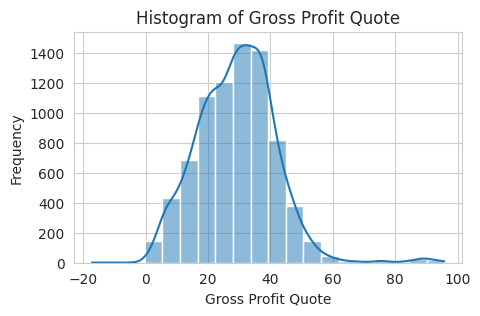

In [ ]:
plt.figure(figsize=(5, 3))
sns.histplot(data=df, x='Gross Profit Quote', bins=20, kde=True)
plt.title('Histogram of Gross Profit Quote')
plt.xlabel('Gross Profit Quote')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df['Gross Profit Quote'].min()

-17.2

In [ ]:
df['Gross Profit Quote'].max()

95.7

We see an even distribution with a little tail. Most companies fall in the space around 30-40 points. What would be interesting is what types of companies have the highest values of Gross Profit Quote:

In [ ]:
profit_quote_by_type_sorted = df.groupby('Type')['Gross Profit Quote'].mean()

In [ ]:
top_10_types = profit_quote_by_type_sorted.nlargest(10)

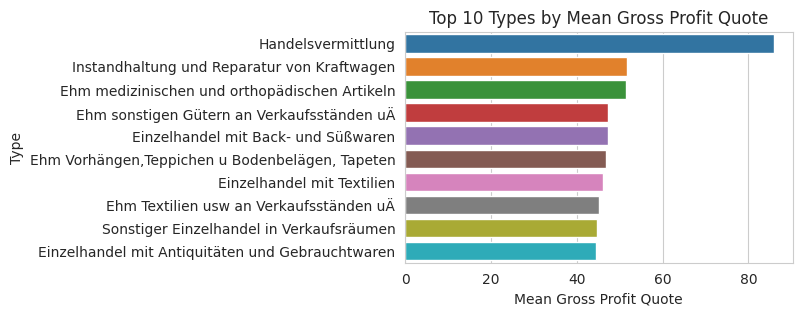

In [ ]:
plt.figure(figsize=(5, 3))
sns.barplot(x=top_10_types.values, y=top_10_types.index.tolist())
plt.title('Top 10 Types by Mean Gross Profit Quote')
plt.xlabel('Mean Gross Profit Quote')
plt.ylabel('Type')
plt.show()

Interesting. The most profitable Type by a big margin is 'Handelsvermittlung'. This is somehow an outlier, as a trade agency has to buy no goods and therefore low values in 'Cost of Sales' which drives 'Mean Gross Profit Quote' high.

Another interesting question is what the revenue shares of the top companies are. Lets calculate the revenue by business type and then do a cumulative sum of the top 50% of the revenue shares:

In [ ]:
revenue_sum = df['Revenue'].sum()

In [ ]:
revenue_by_type = ((df.groupby('Type')['Revenue'].sum())/revenue_sum)*100

In [ ]:
# Quick validation if the sum is 100:
revenue_by_type.sum()

100.0

In [ ]:
revenue_by_type_sorted = revenue_by_type.sort_values(ascending=False)

cumulative_percentages = revenue_by_type_sorted.cumsum()

top_50_percent_index = (cumulative_percentages >= 50).idxmax()

top_50_percent_values = revenue_by_type_sorted.loc[:top_50_percent_index]

In [ ]:
top_50_percent_values_sorted = top_50_percent_values.sort_values(ascending=False)

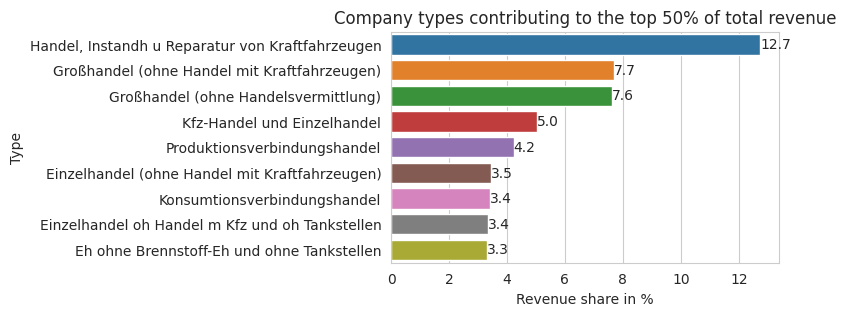

In [ ]:
plt.figure(figsize=(5, 3))

barplot = sns.barplot(x=top_50_percent_values_sorted.values, y=top_50_percent_values_sorted.index.tolist())

barplot.bar_label(barplot.containers[0], fmt='%.1f')

plt.title('Company types contributing to the top 50% of total revenue')
plt.xlabel('Revenue share in %')
plt.ylabel('Type')
plt.show()

These are the company types with the highest share of revenues. It doesn't mean they are profitable though.


### Summary: Profit and Revenue

Profit Distribution: 'Handelsvermittlung' outfits spotlight high profit quotes, suggesting a more profitable edge. This can however be attributed to this indistry being a contractor and not a retailer like the other companies in the dataset.

Revenue Dynamics: Certain sectors dominate in revenue contribution, showing their market influence.

For a further analysis on Profit please continue reading to "Part 4 - Deep dive on company types: Profit and it's influencers"

## Part 2 - Company Sizes

### Analysis: Company Sizes

In this part I will explore:

- the feature company Size
- and how it influences profits.

In [ ]:
grouped = df.groupby('Size')['Employees'].sum().reset_index()

In [ ]:
total_employees = grouped['Employees'].sum()

In [ ]:
grouped['Percentage'] = (grouped['Employees'] / total_employees) * 100

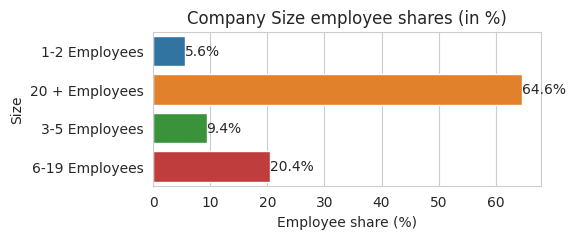

In [ ]:
plt.figure(figsize=(5, 2))
barplot = sns.barplot(x=grouped['Percentage'], y=grouped['Size'])
barplot.bar_label(barplot.containers[0], fmt='%.1f%%')
plt.title('Company Size employee shares (in %)')
plt.xlabel('Employee share (%)')
plt.ylabel('Size')
plt.show()

We see that most of the employees work in firms of 20+ employees.


Next we will have a look on the Size of the company types and how it influences profits in regard to the profit per employee.

In [ ]:
# Create a new column 'Profit by employee', measured in thousands:

df['Profit by Employee'] = df['Profit']*1000/df['Employees']

In [ ]:
employee_profit_by_size_sorted = df.groupby('Size')['Profit by Employee'].mean().sort_values(ascending=False)

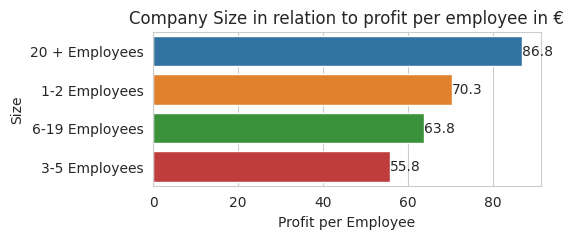

In [ ]:
plt.figure(figsize=(5, 2))

barplot = sns.barplot(x=employee_profit_by_size_sorted.values, y=employee_profit_by_size_sorted.index.tolist())

barplot.bar_label(barplot.containers[0], fmt='%.1f')

plt.title('Company Size in relation to profit per employee in €')
plt.xlabel('Profit per Employee')
plt.ylabel('Size')
plt.show()

We can see that being a company of 20+ people has the most influence on earning profits by employee.

Unfortunately we do not have a finer granularity here, as the bin of 20+ employees is very big.

Reasons for the high profit/employee at companies with this size can be scaling effects. Bigger companies profit from better negotiating positions which lead to lower prices. Also more throughput of the processes lead to better feasability of automation which lessens cost.

### Summary: Company Sizes:

Dominance of big sized Firms: Most staff work in big-scale companies, indicating their significant footprint in the sector. However, the bin of 20+ is very big, so we can't distinguish it any further.

Profit Insights: Companies with 20+ employees have the peak profit margins per employee. This can be attributed to better scaling effects.

This snapshot underscores the weight of big sized entities in the landscape and the nuances of having better profit per employee with mid sized company sizes.

## Part 3 - Development of key figures over time

### Analysis: Development of key figures over time

This is the final part of the EDA. We want to investigate how the above figures changed over time. The time span will be from 2005-2020 , so 16 Years on a yearly basis.

We start with the mean and median gross profit quote for all company types:

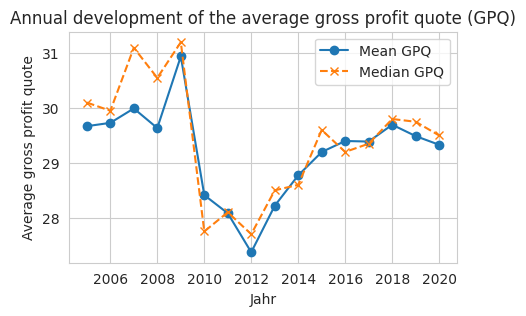

In [ ]:
mean_gross_profit = df.groupby('Year')['Gross Profit Quote'].mean()
median_gross_profit = df.groupby('Year')['Gross Profit Quote'].median()

plt.figure(figsize=(5, 3))
plt.plot(mean_gross_profit.index, mean_gross_profit.values, marker='o', label = 'Mean GPQ')
plt.plot(median_gross_profit.index, median_gross_profit.values, marker='x', linestyle='dashed', label='Median GPQ')
plt.title('Annual development of the average gross profit quote (GPQ)')
plt.xlabel('Jahr')
plt.ylabel('Average gross profit quote')
plt.grid(True)
plt.legend()
plt.show()

Mean and median follow each other quite nicely, except for the years 2006-2008, implicating that there are outliers to the floor. However, as they have the same pattern, I will leave it like that

We see a pattern around the year 2009-2012, where the gross profit quote takes a dip. The financial crisis beginning 2008 could be a trigger. However, the quote remains quite stable, as we are talking about a volatility that takes place inbetween 27% and 31%.

To get a better view on the overall volatility, I expand the y-axis to values between 0 and 50%:

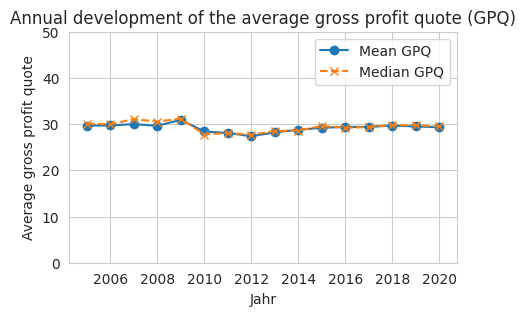

In [ ]:
mean_gross_profit = df.groupby('Year')['Gross Profit Quote'].mean()
median_gross_profit = df.groupby('Year')['Gross Profit Quote'].median()

plt.figure(figsize=(5, 3))
plt.plot(mean_gross_profit.index, mean_gross_profit.values, marker='o', label = 'Mean GPQ')
plt.plot(median_gross_profit.index, median_gross_profit.values, marker='x', linestyle='dashed', label='Median GPQ')
plt.title('Annual development of the average gross profit quote (GPQ)')
plt.xlabel('Jahr')
plt.ylabel('Average gross profit quote')
plt.ylim(0, 50)
plt.grid(True)
plt.legend()
plt.show()

This is a almost stable, continuous line.

Next, we will display the revenue of all company types over time:

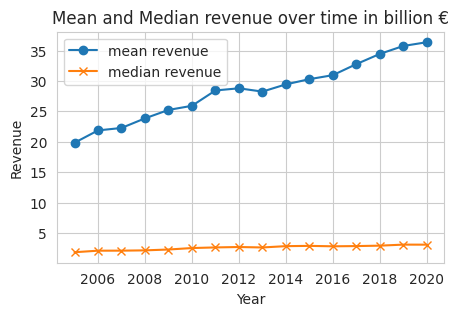

In [ ]:
mean_revenue = df.groupby('Year')['Revenue'].mean()
median_revenue = df.groupby('Year')['Revenue'].median()

# converting to billions for better readability:
median_revenue = median_revenue/1000
mean_revenue = mean_revenue/1000

plt.figure(figsize=(5, 3))
plt.plot(mean_revenue.index, mean_revenue.values, marker='o', label='mean revenue')
plt.plot(median_revenue.index, median_revenue.values, marker='x', label='median revenue')
plt.title('Mean and Median revenue over time in billion €')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.grid(True)
plt.legend()
plt.show()

Good that we made the mean and median split. Here we see a clear distinction not only on the value part (mean is more than 5x higher than the median) but also on the growth.

The reasons for this may be that the revenues within the companies are not equally distributed. This can be the case, if the amount of outliers to the top grows with time as several companies or market sectors yield extraordinary high revenues (top performers), while the majority of companies grows slower

To further investigate, we determine the 5 company types which had the highest rise in mean revenue across the whole timespan:

In [ ]:
df_2005 = df.loc[df['Year'].dt.year == 2005]
revenue_2005 = df_2005.groupby(['Type'])['Revenue'].mean()

In [ ]:
df_2020 = df.loc[df['Year'].dt.year == 2020]
revenue_2020 = df_2020.groupby(['Type'])['Revenue'].mean()

In [ ]:
revenue_delta = (revenue_2020 - revenue_2005)/1000

In [ ]:
top_5_revenues = revenue_delta.sort_values(ascending=False).head(5)

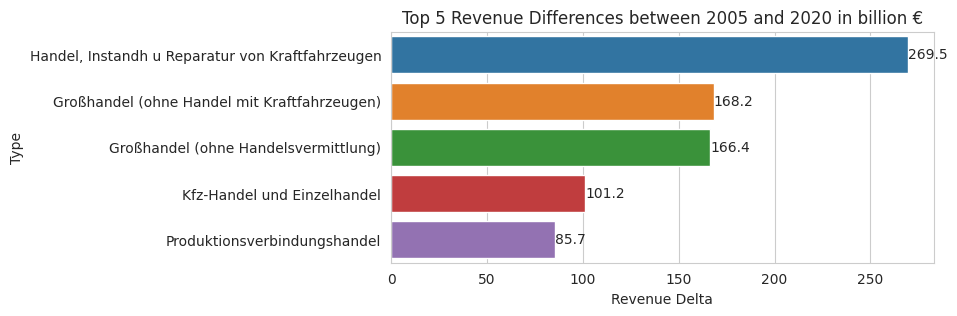

In [ ]:
plt.figure(figsize=(7, 3))

barplot = sns.barplot(x=top_5_revenues.values, y=top_5_revenues.index.tolist())

barplot.bar_label(barplot.containers[0], fmt='%.1f')

plt.title('Top 5 Revenue Differences between 2005 and 2020 in billion €')
plt.xlabel('Revenue Delta')
plt.ylabel('Type')
plt.show()

To get a better understanding, we can also dive deeper into the revenue growths of the 4 different company sizes:

In [ ]:
df_2005_sizes = df.loc[df['Year'].dt.year == 2005]
revenue_2005_sizes = df_2005_sizes.groupby(['Type', 'Size'])['Revenue'].mean()

In [ ]:
df_2020_sizes = df.loc[df['Year'].dt.year == 2020]
revenue_2020_sizes = df_2020_sizes.groupby(['Type', 'Size'])['Revenue'].mean()

In [ ]:
revenue_delta_sizes = (revenue_2020_sizes - revenue_2005_sizes)/1000

In [ ]:
unique_sizes = df['Size'].unique()

filtered_revenues_by_size = {}
top_5_by_size = {}

for size in unique_sizes:
    filtered_revenues = revenue_delta_sizes.xs(size, level='Size')
    filtered_revenues_by_size[size] = filtered_revenues
    top_5_by_size[size] = filtered_revenues.nlargest(5)

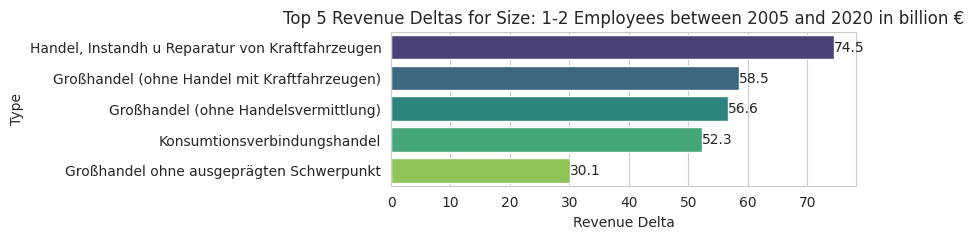

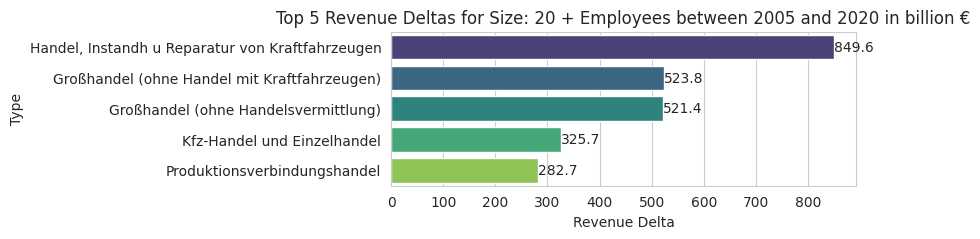

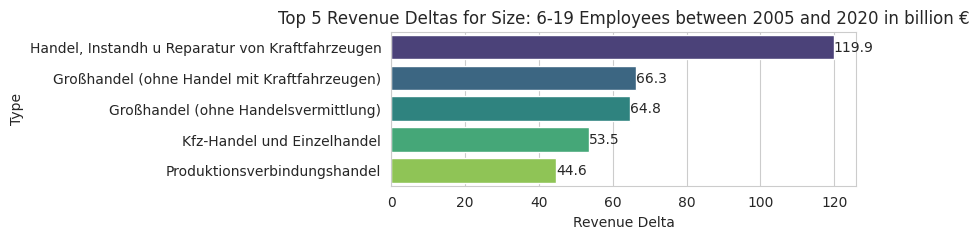

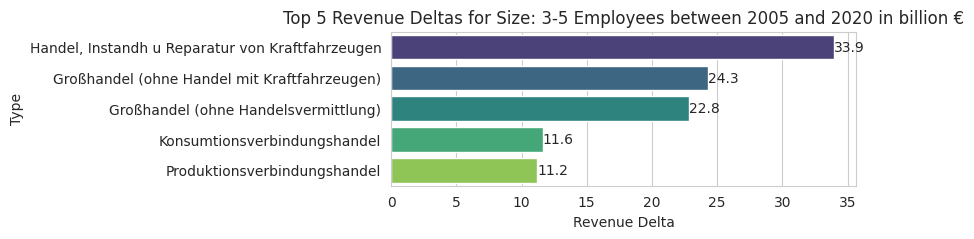

In [ ]:
sns.set_style("whitegrid")

for size, revenues in top_5_by_size.items():
    plt.figure(figsize=(6, 2))
    barplot = sns.barplot(x=revenues.values, y=revenues.index.tolist(), palette="viridis")
    barplot.bar_label(barplot.containers[0], fmt='%.1f')
    plt.title(f'Top 5 Revenue Deltas for Size: {size} between 2005 and 2020 in billion €')
    plt.xlabel('Revenue Delta')
    plt.ylabel('Type')
    plt.show()

We can observe that the Top 5 for every size is roughly the same, however, the revenue growths for the 20+ employee companies have a much higher gain overall in comparison

### Summary: Development of key figures over time

We found out that we have some clear winners in the revenue race over the last 20 years. 4 of the 5 industries raised their revenues substantially, however 'Handel, Insth/Reperatur von Kraftfahrzeugen' is in front by a wide margin above all company sizes.

## Part 4 - Deep dive on company types

### Aggregating company types

To get more out of our data, we can try to cluster it. Before doing so however, I will aggregate the company types.

Looking over the company types we see similarities in the industry branch:

In [ ]:
df['Type'].head(10)

0                          Großhandel mit Tabakwaren
1                   Großhandel mit Uhren und Schmuck
2                          Großhandel mit Tabakwaren
3                        Einzelhandel mit Spielwaren
4                          Großhandel mit Tabakwaren
5    Großhm festen Brennstoffen und Mineralölerzeugn
6    Großhm festen Brennstoffen und Mineralölerzeugn
7    Großhm festen Brennstoffen und Mineralölerzeugn
8    Großhm festen Brennstoffen und Mineralölerzeugn
9           Großhandel ohne ausgeprägten Schwerpunkt
Name: Type, dtype: category
Categories (126, object): ['Apotheken', 'Apotheken, EH mit med,orthopukosmetArtikeln',
                           'Eh ohne Brennstoff-Eh und ohne Tankstellen', 'Ehm Blumen, Pflanzen, Sämereien, Düngem, usw', ...,
                           'Sonstiger Einzelhandel in Verkaufsräumen', 'Sonstiger Einzelhandel mit Waren verschiedene...,
                           'Sonstiger Großhandel', 'Versand- und Internet-Einzelhandel']

First, a quick definition of the different company types:

**Wholesale**: Branch, which deals with mass buying and selling of products from businesses to business

**Retail**: Branch, which deals with buying and selling of products and selling them in smaller amounts to customers

**Pharmacy**: Type of retail, which is specialized in buying and selling of goods from businesses to customers that are regarding drugs and medicines as well as cosmetica in small amounts

**Retail with cars**: Type of retail, which focuses on buying and selling of cars to customers, as well as related services as car-parts and financing of cars.

Several Company Types can be grouped together. Looking over the company types I can see 8 different categories. I will divide food from non food to have a better distinction between fast moving and slower moving consumer goods. Also I will separate retail with cars, and Pharmacy, for them being a special branch of Retail

1. Wholesale with non-food

2. Wholesale with food

3. Wholesale with cars

4. Retail with non-food

5. Retail with food

6. Retail with cars

7. Pharmacy

8. other


First we will separate the data by Wholesale, Retail, Pharmacy and Other:

In [ ]:
wholesale_keywords = ['Großhandel', 'Großhm', 'Konsumtionsverbindungshandel', 'Produktionsverbindungshandel']
retail_keywords = ['Einzelhandel', 'Handel', 'EH mit', 'Eh ohne', 'Ehm', 'Eh ']

In [ ]:
def categorize_trade(type_str):
    if any(keyword in type_str for keyword in wholesale_keywords):
        return 'wholesale'
    elif any(keyword in type_str for keyword in retail_keywords):
        return 'retail'
    elif 'Apotheken' in type_str:
        return 'pharmacy'
    else:
        return 'other'

In [ ]:
df['type_wholesale_retail'] = df['Type'].apply(categorize_trade)

Validate the operation:

In [ ]:
df['type_wholesale_retail'].unique()

array(['wholesale', 'retail', 'pharmacy', 'other'], dtype=object)

Looks good! Next, we will further separate wholesale and retail. I used ChatGPT with a german dictionary to find the food related keywords. However, I had to sort some remaining manually.

In [ ]:
car_keywords = ['Kraftw', 'Krafträder', 'Kraftfahr', 'Kfz']
food_keywords = ['Nahrung','Getreide', 'Milch', 'Eier', 'Speise', 'Fett', 'Getränk', 'Genuss', 'Lebensmitt', 'Back', 'Zucker', 'Fisch', 'Süß', 'Fleisch', 'Gemüse', 'Kaffe','Kakao' ]

In [ ]:
def categorize_food(type):
    if any(keyword in type for keyword in car_keywords):
        return 'cars'
    elif any(keyword in type for keyword in food_keywords):
        return 'food'
    else:
      return 'non food'

In [ ]:
df['type_food_cars'] = df['Type'].apply(categorize_food)

Quick validation:

In [ ]:
df['type_food_cars'].unique()

array(['non food', 'food', 'cars'], dtype=object)

Next, we stitch together both columns. We want to leave 'other' and 'pharmacy' the same.

In [ ]:
valid_rows = (df['type_wholesale_retail'] == 'wholesale') | (df['type_wholesale_retail'] == 'retail')

other_rows = (df['type_wholesale_retail'] == 'other') | (df['type_wholesale_retail'] == 'pharmacy')

df.loc[valid_rows, 'trade_type'] = df['type_wholesale_retail'] + ' ' + df['type_food_cars']

df.loc[other_rows, 'trade_type'] = df['type_wholesale_retail']

In [ ]:
df['trade_type'].unique()

array(['wholesale non food', 'retail non food', 'wholesale food',
       'retail cars', 'wholesale cars', 'retail food', 'pharmacy',
       'other'], dtype=object)

Finally we have all types in the column. I will omit the two helper columns 'type_wholesale_retail' and 'type_food_cars' as we have all the information in our new column.

In [ ]:
df.drop(columns=['type_wholesale_retail', 'type_food_cars'], inplace=True)

Viewing the proportions of the different trade types:

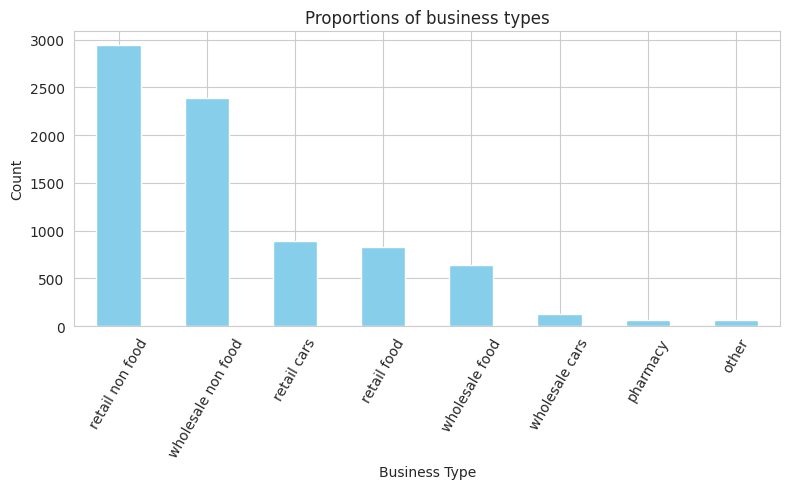

In [ ]:
trade_type_counts = df['trade_type'].value_counts()

plt.figure(figsize=(8, 5))
trade_type_counts.plot(kind='bar', color='skyblue')
plt.title('Proportions of business types')
plt.xlabel('Business Type')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

### Deep dive on company types profits and it's influencers

Now we can do a further analysis how profitable those business types are:

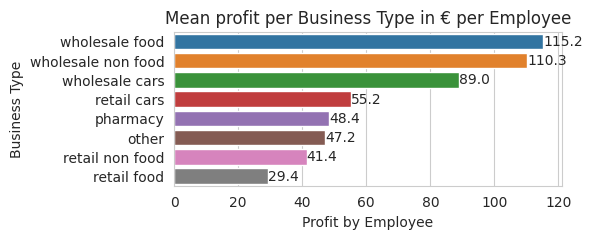

In [ ]:
df_sorted = df.sort_values('Profit by Employee', ascending=False)
order = df.groupby('trade_type')['Profit by Employee'].mean().sort_values(ascending=False).index

plt.figure(figsize=(5, 2))
barplot = sns.barplot(x='Profit by Employee', y='trade_type', data=df_sorted, errorbar=None, order=order)
barplot.bar_label(barplot.containers[0], fmt='%.1f')
plt.title('Mean profit per Business Type in € per Employee')
plt.xlabel('Profit by Employee')
plt.ylabel('Business Type')
plt.show()

Interesting, "Wholesale food" followed by "Wholesale non-food" are the most profitable branches regarding profit / employee.

Now we can add both dimensions of business type and business size together:

In [ ]:
# Removing 3 values which are below 0 and are hindering the heatmap
df = df[df['Profit by Employee'] >= 0]

In [ ]:
pivot_table = df.pivot_table(values='Profit by Employee', index='Size', columns='trade_type', aggfunc='mean')

fig = px.imshow(pivot_table, color_continuous_scale='Viridis_r', title='Heatmap: Profit by Employee')
fig.update_traces(showscale=True)
fig.update_layout(coloraxis_colorbar_title="Profit by Employee")
fig.show()

The heatmap shows us an interesting picture: trading companies that are between 100 and 150 employees in size, and are of the "wholesale" type, make the greatest profits per employee.

For some sectors, such as pharmacy, there are no data with more than 50 employees, which underlines the fact that this type of company tends to be smaller in principle.

As far as the company type 'Wholesale' is concerned, economies of scale are again evident here: By definition, wholesale is a branch that deals with the mass buying and selling of goods.

The wholesale of cars is not as affected as the other goods however.

Lets have a look on the profits in general:

In [ ]:
df['Profit_in_billions'] = df['Profit']/1000

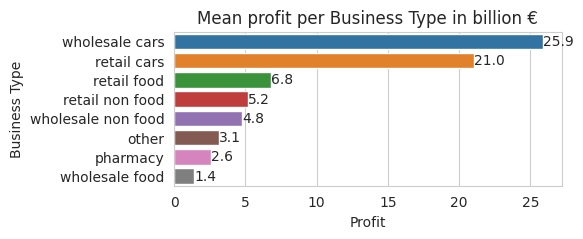

In [ ]:
order = df.groupby('trade_type')['Profit_in_billions'].mean().sort_values(ascending=False).index
plt.figure(figsize=(5, 2))
barplot = sns.barplot(x=df['Profit_in_billions'], y='trade_type', data=df_sorted, order=order, errorbar=None)
barplot.bar_label(barplot.containers[0], fmt='%.1f')
plt.title('Mean profit per Business Type in billion €')
plt.xlabel('Profit')
plt.ylabel('Business Type')
plt.show()


In [ ]:
pivot_table = df.pivot_table(values='Profit', index='Size', columns='trade_type', aggfunc='mean')

fig = px.imshow(pivot_table, color_continuous_scale='Viridis_r', title='Heatmap: Profit')
fig.update_traces(showscale=True)
fig.update_layout(coloraxis_colorbar_title="Profit")
fig.show()

We see a clear winner here, with 'wholesale cars' followed by 'retail' cars gained the most profits.

# Conclusion

This brings me to the end of the analysis. The goal was to show the relevant figures and findings of the dataset. The most important findings were:

**Part 1: profit and sales:**
Gross Profit Ratio:

Most businesses have gross profit ratios in the 30-40 point range. This suggests that there is a general consistency in profitability across different business types.
However, the "Handelsvermittlung" (commercial agency) business type stands out as an outlier, with its exceptionally high gross profit ratio mainly due to low values in the "cost of sales". It was most likely an error by Destatis while creating the dataset.

**Part 2: company sizes:**
Profit per employee:

Larger companies tend to achieve higher profit per employee. This could be due to economies of scale, better bargaining power or more efficient operations.

**Part 3: Development of key figures over time:**

There are significant differences in profit and revenue growth from 2005 to 2020, with companies with 20+ employees showing the highest profits.
It is worth noting that the companies that have experienced the highest revenue growth over the last 15 years are predominantly among the larger companies. This could indicate that larger companies had better growth opportunities or were better able to respond to market changes compared to smaller companies.

Overall, the analysis shows that there are important differences in profitability and revenue growth between different business types and sizes. These differences provide valuable insights for stakeholders and could serve as a starting point for future investment decisions or business strategies.




# Final thoughts and prospect


Not everything could be covered in this project. Some of the more detailed examinations could be:

The examination of profitability and revenue growth could be further
differentiated to identify industry trends and understand which industries have been particularly successful over the past 15 years.

Examining external factors:
It might be interesting to look at external economic factors (e.g., economic recessions, technological developments) and analyze how they have affected company sales and profits.

Operating costs and capital expenditures:
A deeper examination of operating costs and investments could help understand why certain companies or industries have higher profitability.